In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('belle2')
import numpy as np
import pdg
import root_pandas
import pandas

treefile='../Ntuples/MC_e_50k_cut.root'
df = root_pandas.read_root(treefile)
df=df.drop_duplicates(subset=['__experiment__','__run__','__event__','__production__','__candidate__'])
#df['B0_vetoeID'] = df['B0_vetoeID'].fillna(-1)
#df['B0_vetomuID'] = df['B0_vetomuID'].fillna(-1)
df['B0_isSignal'] = df['B0_isSignal'].fillna(-1)
df['D_isSignal'] = df['D_isSignal'].fillna(-1)
df['e_isSignal'] = df['e_isSignal'].fillna(-1)
df['B0_mcPDG'] = df['B0_mcPDG'].fillna(0)

df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df.eval('p_D_l = D_CMS_p + e_CMS_p', inplace=True)

Welcome to JupyROOT 6.24/06


### Final Cuts and Best Candidate Selection

In [2]:
df_cut=df.query('D_vtxReChi2<7 and B0_vtxReChi2<9 and 5.07<B0_roeMbc_my_mask and B0_roeDeltae_my_mask<0.5 and \
4.65<B0_CMS2_weMbc and abs(B0_roeCharge_my_mask)<3 and 0<=B0_vetoeID<0.9 and 0<=B0_vetomuID<0.9').copy()
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]

In [9]:
# Signal components
sig_D_e_nu=df_bestSelected.query('DecayMode=="sig_D_e_nu" and B0_mcErrors<32 and abs(B0_mcPDG)==511 and abs(D_mcPDG)==411').copy()
sig_D_mu_nu=df_bestSelected.query('DecayMode=="sig_D_mu_nu" and B0_mcErrors<32').copy()
sig_D_tau_nu=df_bestSelected.query('DecayMode=="sig_D_tau_nu" and B0_mcErrors<32').copy()
all_Dst_e_nu=df_bestSelected.query('DecayMode=="all_Dst_e_nu" and (16<=B0_mcErrors<32 or B0_mcErrors<8)').copy()
all_Dst_mu_nu=df_bestSelected.query('DecayMode=="all_Dst_mu_nu" and (16<=B0_mcErrors<32 or B0_mcErrors<8)').copy()
all_Dst_tau_nu=df_bestSelected.query('DecayMode=="all_Dst_tau_nu" and (16<=B0_mcErrors<32 or B0_mcErrors<8)').copy()
all_Dstst_e_nu=df_bestSelected.query('DecayMode=="all_Dstst_e_nu" and (16<=B0_mcErrors<64 or B0_mcErrors<8)').copy()
all_Dstst_mu_nu=df_bestSelected.query('DecayMode=="all_Dstst_mu_nu" and (16<=B0_mcErrors<64 or B0_mcErrors<8)').copy()
all_Dstst_tau_nu=df_bestSelected.query('DecayMode=="all_Dstst_tau_nu" and (16<=B0_mcErrors<64 or B0_mcErrors<8)').copy()

# Bkg components
bkg_fakeD = df_bestSelected.query('abs(D_mcPDG)!=411 and B0_mcErrors!=512 and B0_isContinuumEvent!=1').copy()

bkg_combinatorial = df_bestSelected.query('DecayMode!="bkg" and B0_mcPDG==300553 and abs(D_mcPDG)==411 and B0_mcErrors!=512 and B0_isContinuumEvent!=1').copy()

bkg_sigOtherBDTaudecay = df_bestSelected.query('DecayMode=="bkg" and abs(D_mcPDG)==411 and B0_mcErrors!=512 and B0_isContinuumEvent!=1').copy()

bkg_recoWrongSideB = df_bestSelected.query('((DecayMode=="sig_D_tau_nu" or DecayMode=="sig_D_e_nu" or DecayMode=="sig_D_mu_nu" or \
        DecayMode=="all_Dst_tau_nu" or DecayMode=="all_Dst_e_nu" or DecayMode=="all_Dst_mu_nu") and \
        abs(B0_mcPDG)!=300553 and abs(D_mcPDG)==411 and 32<=B0_mcErrors<64 and B0_isContinuumEvent!=1) or \
    ((DecayMode=="all_Dstst_tau_nu" or DecayMode=="all_Dstst_e_nu" or DecayMode=="all_Dstst_mu_nu" or \
        DecayMode=="all_Dst_tau_nu" or DecayMode=="all_Dst_e_nu" or DecayMode=="all_Dst_mu_nu") and \
        abs(B0_mcPDG)!=300553 and abs(D_mcPDG)==411 and 8<=B0_mcErrors<16 and B0_isContinuumEvent!=1) or \
        (DecayMode!="bkg" and abs(B0_mcPDG)!=300553 and abs(D_mcPDG)==411 and 64<=B0_mcErrors<512 and B0_isContinuumEvent!=1)').copy()
# reconstructing the wrong side: 1. semileptonic in both side; 
#                                2. reco the hadronic B_tag, B_sig other_D_decay;
#                                3. reco B_tag -> D+ D_s, D_s -> tau nu

bkg_recoFakeTracksClusters = df_bestSelected.query('B0_mcErrors==512 and B0_isContinuumEvent!=1').copy()
bkg_continuum = df_bestSelected.query('B0_isContinuumEvent==1').copy()

In [10]:
def statistics(df):
    counts=df.count()
    mean=df.mean()
    std=df.std()
    return f'''counts = %d \nmean = %5.3f \nstd = %5.3f''' %(counts,mean,std)

kwarg={'bins':50, 'histtype':'step','lw':2}

    
def plot_projection(cut,variable):
    (counts1, bins1) = np.histogram(sig_D_tau_nu.query(cut)[variable], bins=50)
    (counts2, bins2) = np.histogram(all_Dst_tau_nu.query(cut)[variable], bins=50)
    factor = 50
    plt.hist(bins1[:-1], bins1, weights=factor*counts1,label=f'D_tau_nu \n{statistics(sig_D_tau_nu.query(cut)[variable])}',alpha=0.6)
    sig_D_e_nu.query(cut)[variable].hist(label=f'D_e_nu \n{statistics(sig_D_e_nu.query(cut)[variable])}',**kwarg)
    
    plt.hist(bins2[:-1], bins2, weights=factor*counts2,label=f'Dst_tau_nu \n{statistics(all_Dst_tau_nu.query(cut)[variable])}',alpha=0.6,histtype='step',lw=2)
    all_Dst_e_nu.query(cut)[variable].hist(label=f'Dst_e_nu \n{statistics(all_Dst_e_nu.query(cut)[variable])}',**kwarg)
    all_Dstst_tau_nu.query(cut)[variable].hist(label=f'all_Dstst_tau_nu \n{statistics(all_Dstst_tau_nu.query(cut)[variable])}',**kwarg)
    all_Dstst_e_nu.query(cut)[variable].hist(label=f'all_Dstst_e_nu \n{statistics(all_Dstst_e_nu.query(cut)[variable])}',**kwarg)
    bkg_fakeD.query(cut)[variable].hist(label=f'bkg_fakeD \n{statistics(bkg_fakeD.query(cut)[variable])}',**kwarg)
    bkg_combinatorial.query(cut)[variable].hist(label=f'bkg_combinatorial \n{statistics(bkg_combinatorial.query(cut)[variable])}',**kwarg)
    bkg_sigOtherBDTaudecay.query(cut)[variable].hist(label=f'bkg_sigOtherBDTaudecay \n{statistics(bkg_sigOtherBDTaudecay.query(cut)[variable])}',**kwarg)
    bkg_recoWrongSideB.query(cut)[variable].hist(label=f'bkg_recoWrongSideB \n{statistics(bkg_recoWrongSideB.query(cut)[variable])}',**kwarg)
    bkg_recoFakeTracksClusters.query(cut)[variable].hist(label=f'bkg_recoFakeTracksClusters \n{statistics(bkg_recoFakeTracksClusters.query(cut)[variable])}',**kwarg)
    bkg_continuum.query(cut)[variable].hist(label=f'bkg_continuum \n{statistics(bkg_continuum.query(cut)[variable])}',**kwarg)
    plt.legend(bbox_to_anchor=(1,1),ncol=3, fancybox=True, shadow=True,labelspacing=1.5)

In [11]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [73]:
df.columns

Index(['__experiment__', '__run__', '__event__', '__production__',
       '__candidate__', '__ncandidates__', '__weight__', 'Ecms', 'IPX', 'IPY',
       ...
       'tag_n_mu', 'tag_n_K', 'tag_n_pi', 'tag_nDaughterNeutralHadrons',
       'tag_nDaughterPhotons', 'DecayMode', 'B_D_ReChi2', 'p_D_l', 'cos_D_l_2',
       'cos_D_l_1'],
      dtype='object', length=307)

In [74]:
import pandas
pandas.set_option('display.max_rows', None)
print(df.isna().sum())

__experiment__                          0
__run__                                 0
__event__                               0
__production__                          0
__candidate__                           0
__ncandidates__                         0
__weight__                              0
Ecms                                    0
IPX                                     0
IPY                                     0
IPZ                                     0
missingMomentumOfEvent                  0
missingMomentumOfEvent_Px               0
missingMomentumOfEvent_Py               0
missingMomentumOfEvent_Pz               0
missingMomentumOfEvent_theta            0
missingMomentumOfEventCMS               0
missingMomentumOfEventCMS_Px            0
missingMomentumOfEventCMS_Py            0
missingMomentumOfEventCMS_Pz            0
missingMomentumOfEventCMS_theta         0
missingEnergyOfEventCMS                 0
missingMass2OfEvent                     0
visibleEnergyOfEventCMS           

In [17]:
sig_D_tau_nu.B0_DminusMode.value_counts()

-1033.0      2132
-99.0        1398
-101033.0     312
-1035.0        95
-1034.0        88
             ... 
-201012.0       1
-101029.0       1
-1099.0         1
-1089.0         1
-101093.0       1
Name: B0_DminusMode, Length: 104, dtype: int64

In [10]:
df.e_genMotherPDG.value_counts()

-15.0        6603
 15.0        5958
 411.0        327
-411.0        255
 421.0        149
 511.0        139
-421.0        120
-511.0        101
 22.0          86
 111.0         44
 221.0         22
 223.0         18
-431.0         17
 431.0         13
 213.0         10
 0.0            9
-4122.0         9
 4122.0         7
 20213.0        7
 113.0          7
 443.0          6
-313.0          6
 313.0          4
 310.0          4
 333.0          3
-213.0          2
 4232.0         2
-11.0           1
-321.0          1
 321.0          1
 323.0          1
-413.0          1
-3324.0         1
-4132.0         1
-323.0          1
 415.0          1
 100213.0       1
 4132.0         1
 2214.0         1
Name: e_genMotherPDG, dtype: int64

In [8]:
bkg_sigOtherBDTaudecay.B0_B0Mode.value_counts()

Series([], Name: B0_B0Mode, dtype: int64)

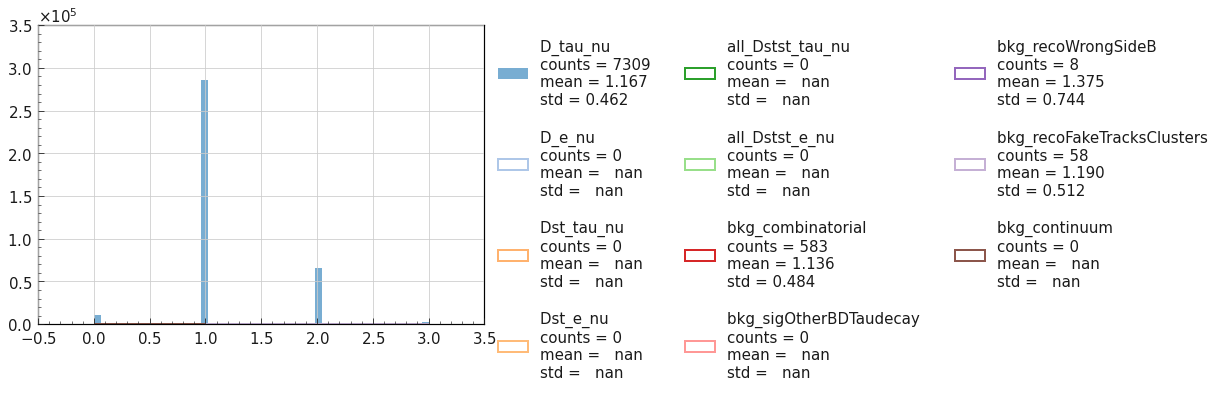

In [6]:
plot_projection('B0_roeMbc_my_mask>5', 'e_nPXDHits')

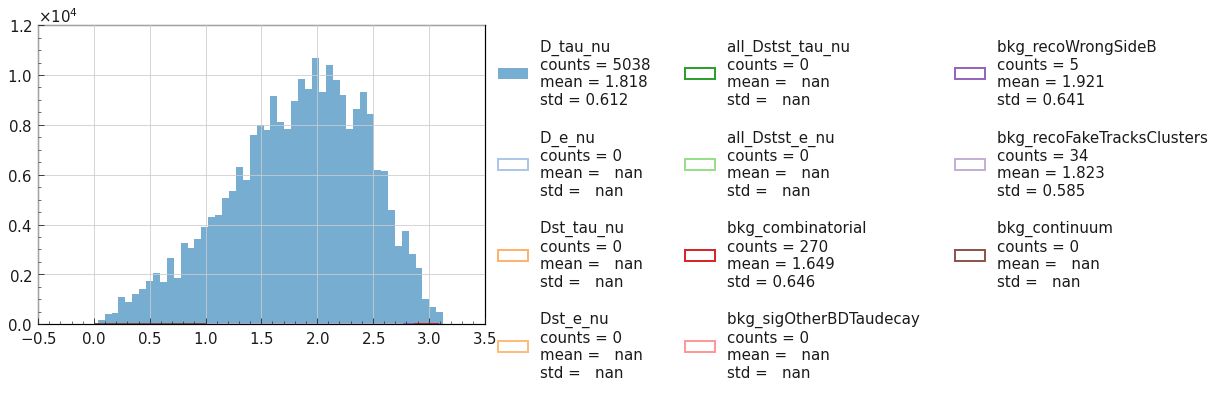

In [7]:
plot_projection('B0_roeMbc_my_mask>5.23', 'B0_sig_daughterAngleLab')

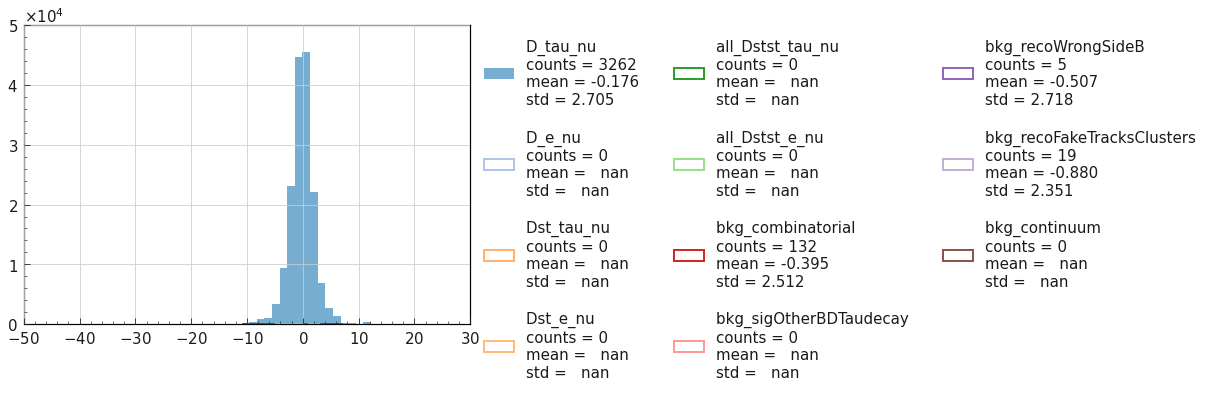

In [14]:
plot_projection('B0_roeMbc_my_mask>5.23', 'B0_flightDistanceSig')

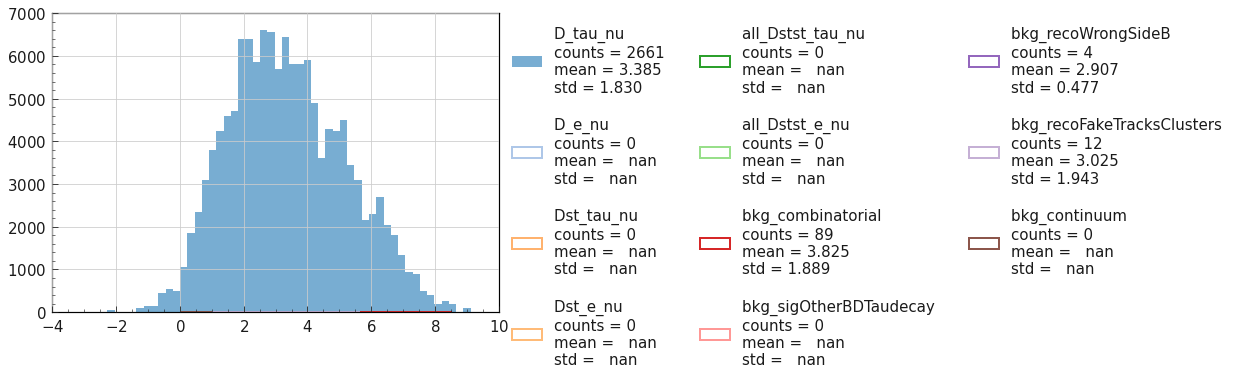

In [10]:
plot_projection('B0_roeMbc_my_mask>5.25', 'B0_CMS2_weMissM2')

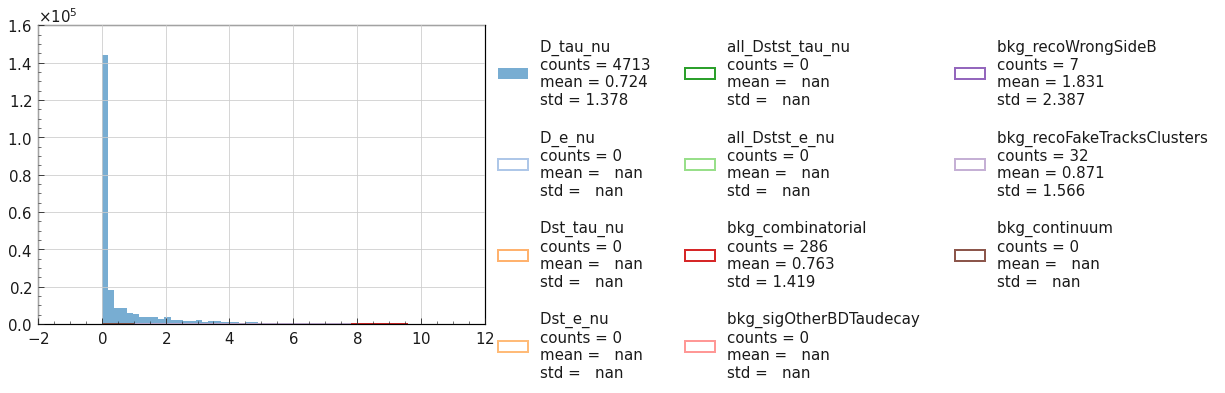

In [47]:
plot_projection('B0_roeMbc_my_mask>5 and 0<B0_roeDistance_high<10', 'B0_roeDistance_high')

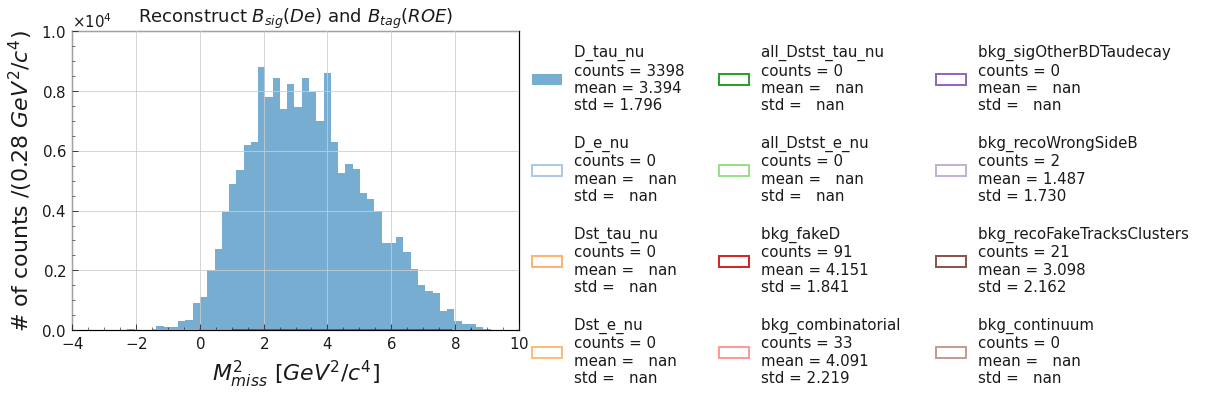

In [12]:
plot_projection('B0_roeMbc_my_mask>5.26', 'B0_CMS2_weMissM2')
plt.xlabel("$M_{miss}^2\ [GeV^2/c^4]$")
plt.ylabel('# of counts /(0.28 $GeV^2/c^4$)')
plt.title('Reconstruct $B_{sig}(De)$ and $B_{tag}(ROE)$');

In [ ]:
plot_components_withcut(cut='e_CMS_p>1.1',variable='MM2')

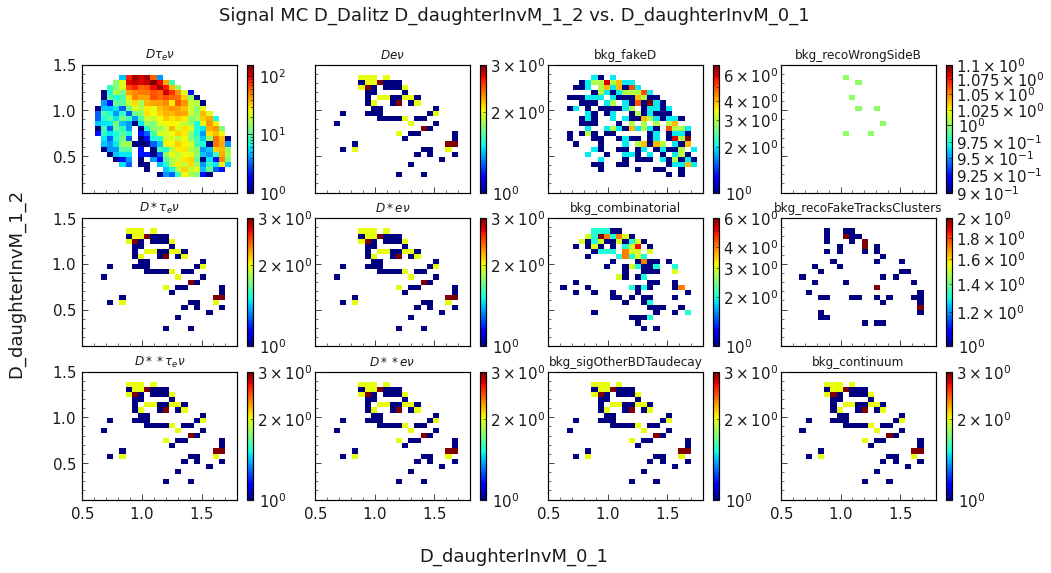

In [16]:
name_list = [r'$D\tau_e\nu$',r'$D*\tau_e\nu$',r'$D**\tau_e\nu$',
             r'$De\nu$',r'$D*e\nu$',r'$D**e\nu$',
             'bkg_fakeD','bkg_combinatorial',
             'bkg_sigOtherBDTaudecay','bkg_recoWrongSideB',
             'bkg_recoFakeTracksClusters','bkg_continuum']
df_list = [sig_D_tau_nu,sig_D_tau_nu.query('B0_Mbc>5.28'),sig_D_tau_nu.query('B0_Mbc>5.28'), 
           sig_D_tau_nu.query('B0_Mbc>5.28'),sig_D_tau_nu.query('B0_Mbc>5.28'),sig_D_tau_nu.query('B0_Mbc>5.28'), 
           bkg_fakeD,bkg_combinatorial,sig_D_tau_nu.query('B0_Mbc>5.28'),
           bkg_recoWrongSideB,bkg_recoFakeTracksClusters, sig_D_tau_nu.query('B0_Mbc>5.28')]   
    
    
df_dict = dict(zip(name_list, df_list))

cuts='B0_roeMbc_my_mask>5'

variable_y = 'D_daughterInvM_1_2'
variable_x = 'D_daughterInvM_0_1'

n_rows,n_cols = [3,4]
fig,ax=plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,8),sharex=True, sharey='all')
fig.suptitle(f'Signal MC D_Dalitz {variable_y} vs. {variable_x}')
fig.supxlabel(f'{variable_x}')
fig.supylabel(f'{variable_y}',x=0.06)
k=0
for j in range(n_cols):
    for i in range(n_rows):
        counts, xedges, yedges, im = ax[i,j].hist2d(df_dict[name_list[k]].query(cuts)[variable_x],
                                                    df_dict[name_list[k]].query(cuts)[variable_y],
                                                    range=[[0.5,1.8],[0.1,1.5]],bins=25,cmap='jet',
                                                    norm=colors.LogNorm())
        ax[i,j].set_title(name_list[k],fontsize=12)
        fig.colorbar(im,ax=ax[i,j])
        k+=1

#plt.xlabel('$p_{D}+p_{l}\ [GeV/c]$')
#plt.ylabel('$M_{miss}^2\ [GeV^2/c^4]$')

Text(0, 0.5, 'withROE ${m_{missing}}^2$')

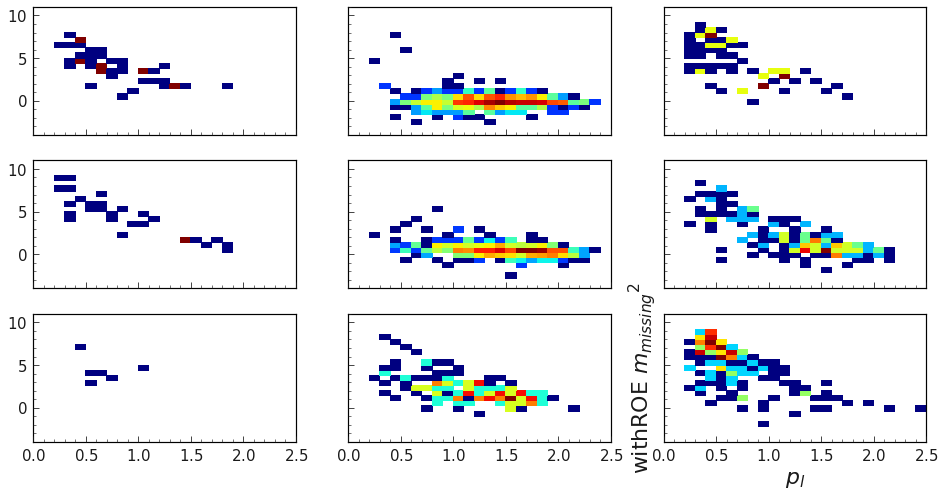

In [22]:
name_list = [r'$D\tau_e\nu$',r'$D*\tau_e\nu$',r'$D**\tau_e\nu$',
             r'$De\nu$',r'$D*e\nu$',r'$D**e\nu$',
             'bkg_misIdAndTwoD','bkg_combinatorial','bkg_randomComb']
df_list = [D_tau_nu,Dst_tau_nu,Dstst_tau_nu, 
           D_e_nu,Dst_e_nu,Dstst_e_nu, 
           df_bkg_misIdAndTwoD,df_bkg_comb,df_bkg_randomComb]

df_dict = dict(zip(name_list, df_list))

cuts='B0_roeMbc_my_mask>5.25 and abs(B0_roeDeltae_my_mask)<0.5'

n_rows,n_cols = [3,3]
fig,ax=plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,8),sharex=True, sharey='all')
k=0
for j in range(n_cols):
    for i in range(n_rows):
        ax[i,j].set_title=name_list[k]
        ax[i,j].hist2d(df_dict[name_list[k]].query(cuts).e_CMS_p, df_dict[name_list[k]].query(cuts).MM2,
                       range=[[0,2.5],[-4,11]],bins=25,cmap='jet',norm=colors.LogNorm())
        k+=1
plt.xlabel('$p_l$')
plt.ylabel('withROE ${m_{missing}}^2$')

In [2]:
np.reshape(df.columns,(1,375))

array([['__experiment__', '__run__', '__event__', '__candidate__',
        '__ncandidates__', '__weight__', 'Ecms', 'IPX', 'IPY', 'IPZ',
        'missingMomentumOfEvent', 'missingMomentumOfEvent_Px',
        'missingMomentumOfEvent_Py', 'missingMomentumOfEvent_Pz',
        'missingMomentumOfEvent_theta', 'missingMomentumOfEventCMS',
        'missingMomentumOfEventCMS_Px', 'missingMomentumOfEventCMS_Py',
        'missingMomentumOfEventCMS_Pz',
        'missingMomentumOfEventCMS_theta', 'missingEnergyOfEventCMS',
        'missingMass2OfEvent', 'visibleEnergyOfEventCMS',
        'totalPhotonsEnergyOfEvent', 'B0_CMS_px', 'B0_CMS_py',
        'B0_CMS_pz', 'B0_CMS_pt', 'B0_CMS_p', 'B0_CMS_E', 'B0_Mbc',
        'B0_deltaE', 'B0_M', 'B0_ErrM', 'B0_SigM', 'B0_InvM',
        'B0_isSignal', 'B0_mcErrors', 'B0_mcPDG', 'B0_dM', 'B0_Q',
        'B0_dQ', 'B0_missingMass2OfEvent', 'B0_m2Recoil', 'B0_cos_pV',
        'B0_cos_pB', 'B0_vtxReChi2', 'B0_vtxNDF', 'B0_vtxDD',
        'B0_vtxDDSig', 'B0_Decay

## 1. $De$

In [3]:
De_info= df[['B0_CMS_p','B0_CMS_E','B0_deltaE','B0_Mbc', 'B0_SigM', 'B0_InvM',
             'B0_dM', 'B0_Q','B0_dQ','B0_isSignal', 'B0_missingMass2OfEvent', 
             'B0_m2Recoil', "B0_R2","B0_thrustBm","B0_thrustOm","B0_cosTBTO","B0_cosTBz","B0_isContinuumEvent",
             'B0_vtxReChi2', 'B0_vtxDD','B0_vtxDDSig','DecayMode','MM2']]
De_info.describe()

,B0_CMS_p,B0_CMS_E,B0_deltaE,B0_Mbc,B0_SigM,B0_InvM,B0_dM,B0_Q,B0_dQ,B0_isSignal,B0_mcErrors,B0_mcPDG,B0_missingMass2OfEvent,B0_m2Recoil,B0_cos_pV,B0_cos_pB,B0_vtxReChi2,B0_vtxDD,B0_vtxDDSig,MM2
count,518916.000000,518916.000000,518916.000000,518916.000000,518915.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000,518916.000000
mean,1.135540,3.068158,-2.221620,5.148507,-528.169916,2.824882,-2.468082,0.941180,-2.468309,-0.017369,347.682681,193152.872981,2.255290,55.323866,0.143432,-7.232047,1.743029,0.022828,4.025595,4.791414
std,0.419773,0.606971,0.606971,0.094749,403.611142,0.640601,0.641429,0.641816,0.641816,0.130642,171.229511,144011.538150,5.630029,9.011798,0.711704,9.366804,46.437842,0.059502,5.800442,3.183179
min,0.017095,2.289780,-2.999999,4.900001,-1886.885994,1.957745,-4.006218,-2.294665,-5.704155,-1.000000,8.000000,-20433.000000,-54.342564,12.601125,-1.000000,-770.072503,-24875.333333,0.000089,0.000762,-8.933299
25%,0.822429,2.583570,-2.706209,5.086012,-822.119272,2.327199,-2.962574,0.446891,-2.962599,0.000000,312.000000,511.000000,-0.910414,48.597426,-0.586378,-10.228240,1.043607,0.006667,1.266380,2.213640
50%,1.130800,2.898226,-2.391553,5.167499,-405.933181,2.616998,-2.676108,0.733375,-2.676114,0.000000,432.000000,300553.000000,1.196365,57.211263,0.329430,-4.957428,1.724908,0.012845,2.242125,5.365530
75%,1.454042,3.461608,-1.828171,5.225454,-183.421446,3.186898,-2.108427,1.301062,-2.108427,0.000000,496.000000,300553.000000,4.647124,62.796946,0.826176,-1.364433,2.719641,0.025553,4.260540,7.403519
max,1.992924,6.844397,1.554618,5.289751,125.758816,6.726165,1.465383,4.874872,1.465383,0.000000,512.000000,300553.000000,54.215435,68.701440,1.000000,3.103342,4.999966,17.239495,236.426198,11.916469


In [29]:
df.__event__.nunique()

387878

In [5]:
df_bestSelected.query('B0_roeMbc_my_mask>5.26 and abs(B0_roeDeltae_my_mask)<0.5').groupby(['B0_mcPDG','DecayMode']).__event__.nunique().unstack()

DecayMode,D_e_nu,D_mu_nu,D_tau_nu,Dst_e_nu,Dst_mu_nu,Dst_tau_nu,Dstst_e_nu,Dstst_mu_nu,Dstst_tau_nu,bkg
B0_mcPDG,,,,,,,,,,
-511.0,366,0,19,277,0,12,60,0,3,25
0.0,4,0,1,7,0,0,3,0,0,6
511.0,437,0,21,361,0,14,81,0,3,29
30443.0,0,0,0,0,0,0,0,0,0,2
300553.0,13,0,1,84,1,2,35,4,3,114


In [31]:
df2=df.groupby(['__ncandidates__','B0_mcPDG']).__event__.nunique().unstack(level=0,fill_value=0)
df2

__ncandidates__,1,2,3,4,5,6,7,8,9,10,12,15,16,20
B0_mcPDG,,,,,,,,,,,,,,
-20413.0,9,3,2,0,0,0,0,0,0,0,0,0,0,0
-10431.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
-10413.0,52,50,11,3,1,1,0,0,0,0,0,0,0,0
-10411.0,11,12,0,2,0,0,0,0,0,0,0,0,0,0
-511.0,54637,21369,2317,1908,29,368,4,32,19,5,7,1,0,0
-421.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
-415.0,12,5,4,2,0,0,0,0,0,0,0,0,0,0
-411.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
-44.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


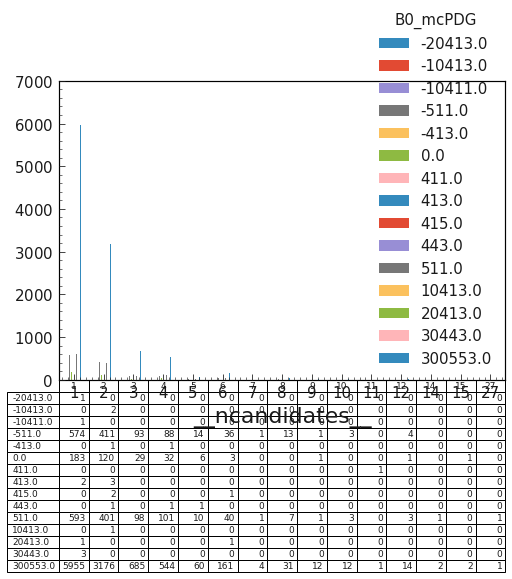

In [8]:
df2.transpose().plot.bar(rot=0,table=True)

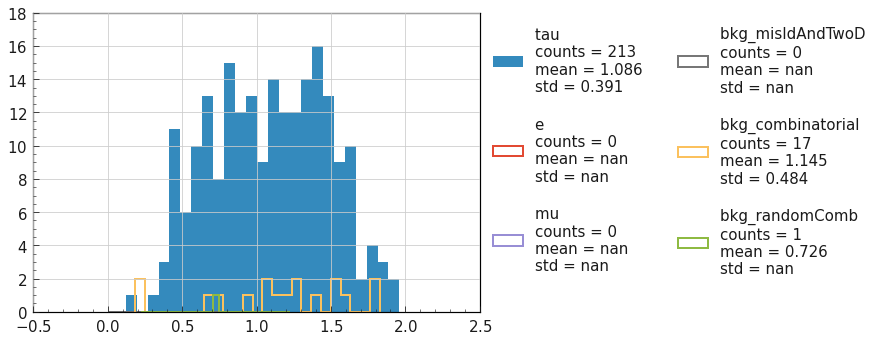

In [5]:
plot_components('B0_CMS_p')

## 2. Tag B

### 2.1 Tag Kimematics

In [83]:
roe_kin= df[['B0_CMS_roeE_my_mask','B0_roeM_my_mask', 'B0_CMS_roeP_my_mask', 'B0_CMS_roePt_my_mask',
              'B0_roeMbc_my_mask','B0_roeDeltae_my_mask',
              'B0_roeCharge_my_mask','B0_roeNeextra_my_mask', 'B0_roeEextra_my_mask',
              'B0_nROE_Charged_my_mask', 'B0_nROE_ECLClusters_my_mask','nROE_KLMClusters',
              'B0_nROE_NeutralECLClusters_my_mask', 'B0_nROE_NeutralHadrons_my_mask',
              'B0_nROE_Photons_my_mask','B0_nROE_Tracks_my_mask', 'B0_nROE_RemainingTracks_my_mask']]
roe_kin.describe()

,B0_CMS_roeE_my_mask,B0_roeM_my_mask,B0_CMS_roeP_my_mask,B0_CMS_roePt_my_mask,B0_roeMbc_my_mask,B0_roeDeltae_my_mask,B0_roeCharge_my_mask,B0_roeNeextra_my_mask,B0_roeEextra_my_mask,B0_nROE_Charged_my_mask,B0_nROE_ECLClusters_my_mask,B0_nROE_NeutralECLClusters_my_mask,B0_nROE_NeutralHadrons_my_mask,B0_nROE_Photons_my_mask,B0_nROE_Tracks_my_mask,B0_nROE_RemainingTracks_my_mask,B0_DeltaT,B0_DeltaTErr,B0_DeltaZ
count,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.0,5.995000e+03,5995.000000,5996.000000
mean,4.486501,4.269269,1.135293,0.897557,5.133804,-0.803278,0.066511,1.454391,2.626099,5.111019,11.436073,8.063177,1.897650,8.063177,5.111019,0.0,3.625022e+02,0.875405,3.491107
std,1.577798,1.389972,1.081975,1.001991,0.214798,1.577798,0.978977,0.903907,0.935393,2.127405,4.395450,4.093136,1.271639,4.093136,2.127405,0.0,2.353433e+04,1.906340,238.590734
min,0.925886,0.288476,0.035749,0.011199,0.000000,-4.363892,-4.000000,0.000000,0.212568,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,-4.926500e+03,0.177607,-40.426416
25%,3.553138,3.243350,0.675520,0.469157,5.076953,-1.736640,0.000000,0.710546,1.955260,4.000000,8.000000,5.000000,1.000000,5.000000,4.000000,0.0,-1.196480e+00,0.361479,-0.010394
50%,4.452758,4.277493,1.038651,0.783967,5.186807,-0.837021,0.000000,1.346039,2.603764,4.000000,11.000000,8.000000,2.000000,8.000000,4.000000,0.0,5.520281e-02,0.472464,0.000554
75%,5.351805,5.261190,1.485366,1.213895,5.246469,0.062026,1.000000,2.055849,3.253364,6.000000,15.000000,11.000000,3.000000,11.000000,6.000000,0.0,1.418803e+00,0.712667,0.012363
max,56.146154,24.402168,50.922257,46.660781,5.289658,50.856375,5.000000,6.966502,7.560888,15.000000,33.000000,25.000000,7.000000,25.000000,15.000000,0.0,1.790615e+06,49.776802,18342.149654


### 2.2 Tag Vertex

In [2]:
roe_vertex = df[['B0_TagVLBoost', 'B0_TagVLBoostErr', 'B0_TagVOBoost',
                 'B0_TagVOBoostErr', 'B0_TagVpVal', 'B0_TagVNDF', 'B0_TagVChi2',
                 'B0_TagVChi2IP', 'B0_TagVx', 'B0_TagVxErr', 'B0_TagVy',
                 'B0_TagVyErr', 'B0_TagVz','B0_TagVzErr']]
roe_vertex.describe()

,B0_TagVLBoost,B0_TagVLBoostErr,B0_TagVOBoost,B0_TagVOBoostErr,B0_TagVpVal,B0_TagVNDF,B0_TagVChi2,B0_TagVChi2IP,B0_TagVx,B0_TagVxErr,B0_TagVy,B0_TagVyErr,B0_TagVz,B0_TagVzErr
count,5995.000000,5995.000000,5995.000000,5995.000000,5999.000000,5999.000000,5999.000000,5999.000000,5996.000000,5999.000000,5996.000000,5999.000000,5996.000000,5999.000000
mean,-0.002036,0.004391,-0.049021,0.002368,0.354162,4.351612,5.714174,2.805705,-0.048769,0.002319,0.017000,0.000199,0.005363,0.004393
std,0.063577,0.006678,0.009276,0.000887,0.277692,28.942677,29.181224,114.599631,0.015320,0.000767,0.000017,0.000005,0.062392,0.006705
min,-0.159663,0.000883,-0.380654,0.000827,-1.000000,-1111.000000,-1111.000000,-1111.000000,-0.393031,0.000000,0.016916,0.000000,-0.141989,0.000000
25%,-0.024566,0.001926,-0.052247,0.001793,0.118233,3.355839,3.207053,0.344400,-0.050634,0.001788,0.016991,0.000199,-0.017165,0.001919
50%,-0.003125,0.002552,-0.048900,0.002222,0.291183,4.831875,5.779770,0.928381,-0.049044,0.002228,0.017000,0.000200,0.004095,0.002561
75%,0.019740,0.003751,-0.045851,0.002772,0.547928,7.010810,8.934626,2.003869,-0.047106,0.002779,0.017009,0.000200,0.027277,0.003754
max,4.145695,0.041061,0.430723,0.022583,0.999736,17.109806,30.584852,7724.998047,1.049751,0.023709,0.017081,0.000200,4.033650,0.041228


## 4. $D^+$

In [5]:
D_info=df[['D_CMS_pt','D_CMS_p', 'D_CMS_E', 'D_isSignal', 'D_mcErrors', 'D_mcPDG',
           'D_dM', 'D_BFM', 'D_BFInvM', 'D_vtxReChi2', 'D_vtxNDF']]
D_info.describe()

,D_CMS_pt,D_CMS_p,D_CMS_E,D_isSignal,D_mcErrors,D_mcPDG,D_dM,D_BFM,D_BFInvM,D_vtxReChi2,D_vtxNDF
count,5999.000000,5999.000000,5999.000000,5918.000000,5999.000000,5918.000000,5999.000000,5999.000000,5999.000000,5999.000000,5999.0
mean,1.001232,1.225600,2.261551,0.635857,127.197866,102998.715444,0.000002,1.861265,1.861265,58.231723,4.0
std,0.431063,0.406736,0.220214,0.481230,170.120501,142654.106197,0.000085,0.021082,0.021082,374.526485,0.0
min,0.008451,0.057412,1.870531,0.000000,0.000000,-511.000000,-0.000025,1.800054,1.800054,0.008859,4.0
25%,0.682766,0.939942,2.092626,0.000000,0.000000,-411.000000,0.000000,1.856568,1.856568,1.057507,4.0
50%,1.005407,1.245441,2.246489,1.000000,0.000000,411.000000,0.000000,1.868089,1.868089,2.560800,4.0
75%,1.309280,1.511132,2.403978,1.000000,312.000000,300553.000000,0.000000,1.872071,1.872071,21.580720,4.0
max,2.725328,4.202374,4.599515,1.000000,512.000000,300553.000000,0.006247,1.899992,1.899992,15694.783203,4.0


In [13]:
df.groupby(['B0_isSignal','D_isSignal']).D_isSignal.count().unstack(level=-1,fill_value=0)

D_isSignal,0.0,1.0
B0_isSignal,,
-1.0,1,4
0.0,2154,1173
1.0,0,2586


In [10]:
df.D_roeDistance_high.head(10)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: D_roeDistance_high, dtype: float64

In [ ]:
plot_projection('B0_roeMbc_my_mask>5', 'D_roeDistance_high')

## 5. $e^-$

In [38]:
e_info=df[['e_CMS_pt', 'e_CMS_p','e_CMS_E', 'e_M', 'e_ErrM', 'e_SigM', 'e_InvM', 'e_isSignal',
           'e_mcErrors', 'e_mcPDG', 'e_dM', 'e_isBremsCorrected']]
e_info.describe()

,e_CMS_pt,e_CMS_p,e_CMS_E,e_M,e_ErrM,e_SigM,e_InvM,e_isSignal,e_mcErrors,e_mcPDG,e_dM,e_isBremsCorrected
count,5999.000000,5999.000000,5999.000000,5999.000000,3123.000000,2931.000000,5999.000000,5994.000000,5999.000000,5994.000000,5999.000000,5999.000000
mean,0.615114,0.726514,0.726515,0.000661,0.001062,0.106598,0.000661,0.851018,76.411402,-1.993827,0.000150,0.019337
std,0.320569,0.351004,0.351005,0.001432,0.002512,0.681543,0.001432,0.356101,249.385932,92.401489,0.001432,0.137716
min,0.048938,0.082709,0.082710,0.000511,0.000000,0.000000,0.000511,0.000000,0.000000,-2212.000000,0.000000,0.000000
25%,0.371372,0.458237,0.458237,0.000511,0.000172,0.000000,0.000511,1.000000,0.000000,-11.000000,0.000000,0.000000
50%,0.554124,0.675068,0.675068,0.000511,0.000448,0.000000,0.000511,1.000000,0.000000,-11.000000,0.000000,0.000000
75%,0.803084,0.941398,0.941398,0.000511,0.001141,0.000000,0.000511,1.000000,0.000000,11.000000,0.000000,0.000000
max,1.961133,2.517238,2.517238,0.035729,0.052352,11.690748,0.035729,1.000000,2048.000000,321.000000,0.035218,1.000000


In [20]:
df.e_2DdistCDC.describe()

count    1.394200e+04
mean     7.763592e+08
std      4.166990e+08
min      1.563678e-02
25%      1.000000e+09
50%      1.000000e+09
75%      1.000000e+09
max      1.000000e+09
Name: e_2DdistCDC, dtype: float64